# Define Synthetic Dataset Blob

In [8]:
# pip install numpy scikit-learn pot matplotlib
from dataclasses import dataclass
import numpy as np, ot
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## Track A - Gaussina mixtures

In [27]:
@dataclass
class DriftConfig:
    d: int = 256; K: int = 10; n_per: int = 250; std_base: float = 1.5
    mode: str = "both"    # "new_component" or "directional_shift"
    w2_incl: float = 0.05; w3_incl: float = 0.25
    incl_std: float = 0.9; incl_dist: float = 5.0
    thr_low: float = 0.8; thr_med: float = 1.6
    seed: int = 47


In [28]:
# Basic N Blobs
def gen_base(cfg, centers=None, n_total=None, seed=None):
    rng = np.random.RandomState(cfg.seed if seed is None else seed)
    C = rng.uniform(-20, 20, size=(cfg.K, cfg.d)) if centers is None else centers
    N = cfg.K*cfg.n_per if n_total is None else n_total
    per = [N//cfg.K]*cfg.K
    per[-1] += N-sum(per)
    Xs, ys = [], []
    for k, nk in enumerate(per):
        if nk<=0: continue
        Xk, yk = make_blobs(n_samples=nk, centers=C[k].reshape(1,-1),
                            cluster_std=cfg.std_base, n_features=cfg.d,
                            random_state=(cfg.seed if seed is None else seed)+10+k)
        yk[:] = k
        Xs.append(Xk); ys.append(yk)
    return (np.vstack(Xs), np.concatenate(ys), C) if Xs else (np.empty((0,cfg.d)), np.empty((0,),int), C)

In [29]:
def gen_new_component(cfg, centers, n_new, seed=None):
    if n_new<=0: return np.empty((0,cfg.d)), np.empty((0,),int)
    rng = np.random.RandomState(cfg.seed if seed is None else seed)
    u = rng.normal(size=cfg.d)
    u/= (np.linalg.norm(u)+1e-12)
    ctr = centers.mean(0) + u*cfg.incl_dist
    X, y = make_blobs(n_samples=n_new, centers=ctr.reshape(1,-1),
                      cluster_std=cfg.incl_std, n_features=cfg.d,
                      random_state=(cfg.seed if seed is None else seed)+100)
    y[:] = centers.shape[0]
    return X, y

def gen_directional_shift(cfg, Xb, yb, n_new, seed=None):
    if n_new<=0: return np.empty((0,Xb.shape[1])), np.empty((0,),int)
    rng = np.random.RandomState(cfg.seed if seed is None else seed)
    u = rng.normal(size=Xb.shape[1]); u/= (np.linalg.norm(u)+1e-12)
    shift = u*cfg.incl_dist
    idx = rng.choice(Xb.shape[0]-1, size=n_new, replace=True)
    X = Xb[idx] + shift + rng.normal(scale=0.25, size=(n_new, Xb.shape[1]))
    return X, yb[idx]

def w2_distance(X1, X2):
    sc = StandardScaler().fit(X1)
    Xr, Xc = sc.transform(X1), sc.transform(X2)
    n = Xr.shape[0]; a = np.ones(n)/n; b = np.ones(n)/n
    M = ot.dist(Xr, Xc)**2
    return np.sqrt((ot.emd(a, b, M)*M).sum())

In [42]:
scatter = lambda X, y: plt.scatter(X[:,0], X[:,1], s=10, c=y)

In [43]:
cfg = DriftConfig(
        mode="both",   # or "new_component"
        w2_incl=0.05, w3_incl=0.35,
        incl_dist=5.0, incl_std=0.9,
        thr_low=0.8, thr_med=1.6, seed=17
    )


In [44]:
X1, y1, C = gen_base(cfg)
N = X1.shape[0]

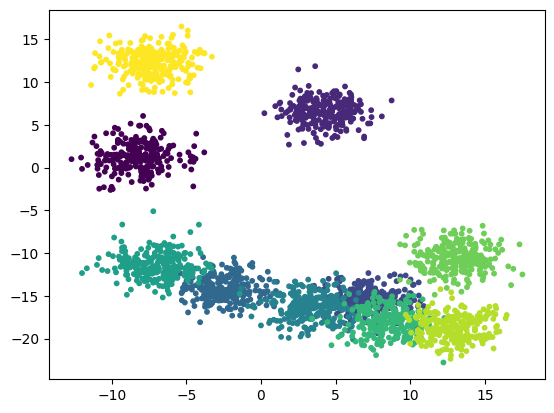

In [48]:
scatter(X1, y1)

In [34]:
split_count = lambda n, w: (n-round(w*n), round(w*n))

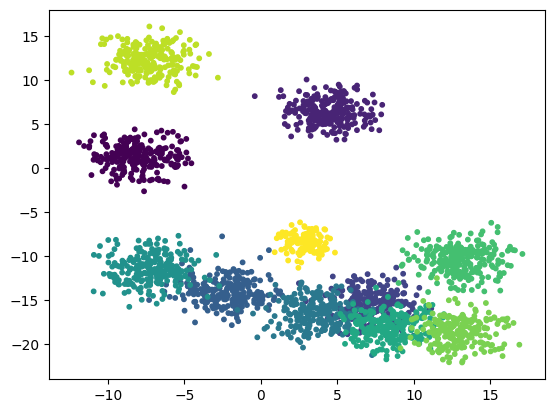

In [62]:
n2b, inc2 = split_count(N, cfg.w2_incl)
X2b, y2b, C2 = gen_base(cfg, centers=C, n_total=n2b, seed=cfg.seed+2)
X2n, y2n = gen_new_component(cfg, C, inc2, seed=cfg.seed+3)
X2, y2 = np.vstack([X2b, X2n]), np.concatenate([y2b, y2n])
scatter(X2, y2)

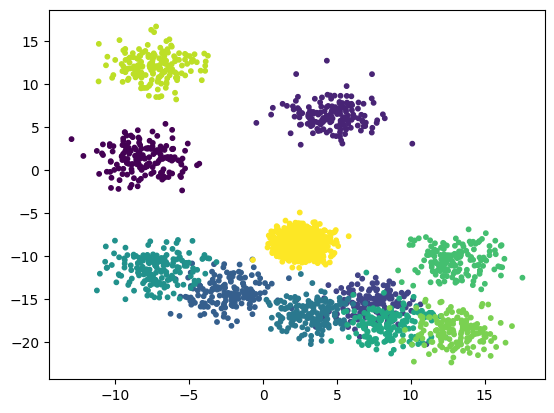

In [63]:
n3b, inc3 = split_count(N, cfg.w3_incl)
X3b, y3b, _ = gen_base(cfg, centers=C, n_total=n3b, seed=cfg.seed+4)
X3s, y3s = gen_directional_shift(cfg, X3b, y3b, inc3, seed=cfg.seed+5)
X3n, y3n = gen_new_component(cfg, C, inc3, seed=cfg.seed+6)
X3, y3 = np.vstack([X3b, X2n, X3n]), np.concatenate([y3b, y2n, y3n])
scatter(X3, y3)

In [64]:
X4, y4, _ = gen_base(cfg, centers=C, n_total=N, seed=cfg.seed+5)

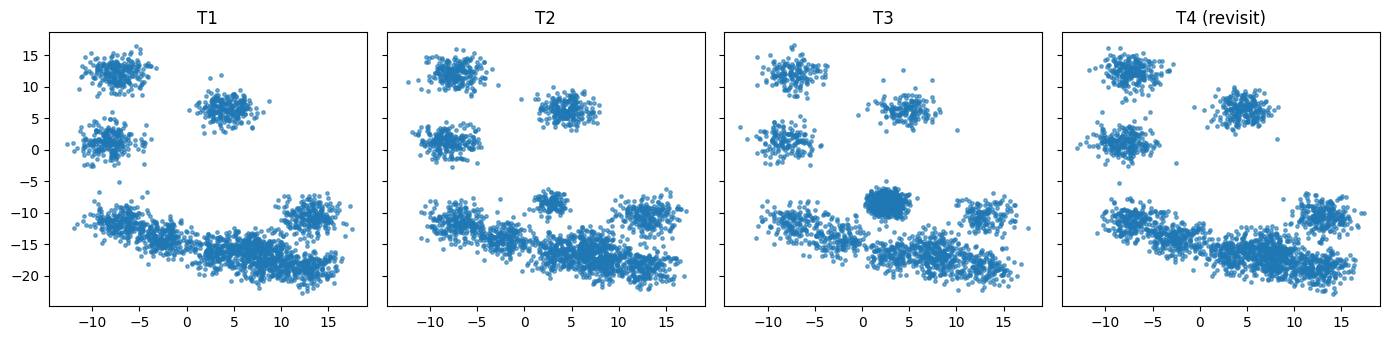

In [65]:
# Optional quick plot
try:
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1,4,figsize=(14,3.5),sharex=True,sharey=True)
    for ax,X,t in zip(axs,[X1,X2,X3,X4],["T1","T2","T3","T4 (revisit)"]):
        ax.scatter(X[:,0],X[:,1],s=6,alpha=0.6); ax.set_title(t)
    plt.tight_layout(); plt.show()
except Exception:
    pass

In [ ]:
w12, w13, w14 = w2_distance(X1, X2), w2_distance(X1, X3), w2_distance(X1, X4)
binf = lambda w: "low" if w<cfg.thr_low else ("medium" if w<cfg.thr_med else "high")

print(f"T1 vs T2: {w12:.3f} -> {binf(w12)}")
print(f"T1 vs T3: {w13:.3f} -> {binf(w13)}")
print(f"T1 vs T4: {w14:.3f} -> {binf(w14)}")

/tmp/ipykernel_23713/975102937.py:8: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter([], [], s=6, alpha=0.8, cmap="tab10")


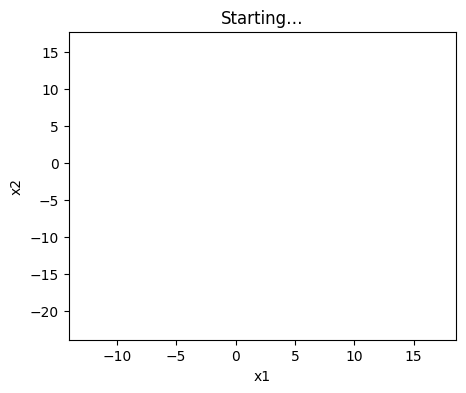

In [67]:
import numpy as np, matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

frames = [("T1", X1, y1), ("T2", X2, y2), ("T3", X3, y3), ("T4 (revisit)", X4, y4)]

fig, ax = plt.subplots(figsize=(5,4))
sc = ax.scatter([], [], s=6, alpha=0.8, cmap="tab10")

allX = np.vstack([X for _, X, _ in frames])
ax.set_xlim(allX[:,0].min()-1, allX[:,0].max()+1)
ax.set_ylim(allX[:,1].min()-1, allX[:,1].max()+1)
ax.set_xlabel("x1"); ax.set_ylabel("x2")

def init():
    sc.set_offsets(np.empty((0,2)))
    sc.set_array(np.array([]))  # clear colors
    ax.set_title("Starting…")
    return sc,

def update(i):
    title, X, y = frames[i]
    sc.set_offsets(X[:, :2])
    sc.set_array(y.astype(float))  # colors by label
    ax.set_title(title)
    return sc,

ani = FuncAnimation(fig, update, frames=len(frames), init_func=init, blit=False, interval=1000, repeat=True)
HTML(ani.to_jshtml())
